# Approximate Nearest Neighbours Search

Sometimes, when we are processing a user query, it may be **acceptable to retrieve a "good guess"** of 
nearest neighbours to the query **instead of true nearest neighbours**. In those cases, one can use an algorithm which doesn't guarantee to return the actual nearest neighbour in every case, **in return for improved speed or memory savings**. Thus, with the help of such algorithms one can do a **fast approximate search in a very large dataset**. Today we will expore one of such approaches based on graphs.

This is what we are going to do in this lab: 

1. Complete implementation of small-world graph;
2. Implement search in this graph;
3. Build a *navigable* small-world graph;
4. Compare search quality in the resulting graphs.


## 1. Dataset preparation
We will utilize the same dataset which was used in the last lab - the [dataset with curious facts](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/facts.txt). Using trained `doc2vec` [model](https://github.com/jhlau/doc2vec) (Associated Press News DBOW (0.6GB), we will infer vectors for every fact and normalize them.


### 1.1 Loading doc2vec model

In [1]:
from gensim.models.doc2vec import Doc2Vec

# unpack a model into 3 files and target the main one
# doc2vec.bin  <---------- this
# doc2vec.bin.syn0.npy
# doc2vec.bin.sin1neg.npy
model = Doc2Vec.load('doc2vec.bin', mmap=None)
print(type(model))
print(type(model.infer_vector(["to", "be", "or", "not"])))

<class 'gensim.models.doc2vec.Doc2Vec'>
<class 'numpy.ndarray'>


### 1.2 Reading data

In [4]:
import urllib.request
data_url = "https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/nlp/facts.txt"
file_name= "facts.txt"
urllib.request.urlretrieve(data_url, file_name)

facts = []
with open(file_name) as fp:
    for cnt, line in enumerate(fp):
        facts.append(line.strip('\n'))

### 1.3 Transforming sentences into vectors

In [5]:
import nltk
import numpy as np

def word_tokenize(sentence):
    return nltk.word_tokenize(sentence.lower())

def get_words_from_sentence(sentences):
    for sentence in sentences: 
        yield word_tokenize(sentence.split('.', 1)[1])

sent_vecs = np.array([])
sent_vecs = np.array(list(model.infer_vector(words) for words in get_words_from_sentence(facts)))

### 1.4 Normalizing vectors

In [6]:
def norm_vectors(A):
    An = A.copy()
    for i, row in enumerate(An):
        An[i, :] /= np.linalg.norm(row)
    return An

def find_k_closest(query, dataset, k=5):    
    index = list((i, v, np.dot(query, v)) for i, v in enumerate(dataset))    
    return sorted(index, key=lambda pair: pair[2], reverse=True)[:k]

sent_vecs_normed = norm_vectors(sent_vecs)

## 2. Small world network ##
We discussed [small world networks](https://en.wikipedia.org/wiki/Small-world_network) in lecture. This beautiful concept utilizes skip-list idea to reach query neighbourhood fastly from any random graph node. You have practically all code written, you just need to complete `rewire()` function with respect to [Watts–Strogatz process](https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model).

**Please write rewiring code.**

Function `build_graph` accepts some iterable collection of `values`. In our case this will be embeddings. 

- `K` is a parameter of Watts–Strogatz model, expressing average degree of graph nodes.
- `p` stands for probability of "rewiring".

In [7]:
import random
class Node:
    ''' Graph node class. Major properties are `value` to access embedding and `neighbourhood` for adjacent nodes '''
    def __init__(self, value, idx):
        self.value = value
        self.idx = idx
        self.neighbourhood = set()
        

def build_graph(values, K, p=0.4):
    '''Accepts container with values. Returns list with graph nodes'''
    
    def rewire(nodes, i, j, k):
        #TODO remove i-j connection and add i-k connection, bi-directional
        # check if k is equal to i
        if i==k or k in nodes[i].neighbourhood:
            return False
        # delete connection (i, j%N) (j%N, i) and add (i,k) (k, i) connection
        nodes[i].neighbourhood.remove(j%N)
        nodes[j%N].neighbourhood.remove(i)
        nodes[i].neighbourhood.add(k)
        nodes[k].neighbourhood.add(i)
        return True
    
        
    N = len(values)
    nodes = [None] * N
    
    # create nodes
    for i, val in enumerate(values):
        nodes[i] = Node(val, i)
    
    # create K-regular lattice
    for i, val in enumerate(nodes):
        for j in range(i - K // 2, i + K // 2 + 1):
            if i != j:
                nodes[i].neighbourhood.add(j % N)
                nodes[j % N].neighbourhood.add(i)
        
    for i, node in enumerate(nodes):
        #TODO for each node rewire right hand side i-j edge to some other random node
        # See Watts–Strogatz model for details
        for j in range(i +1, i + K // 2 + 1): # for K/2 rightmost neighbors
            # take an edge (i, j mod N)
            # generate probability of rewiring 
            beta = random.random()
            if beta>1-p:
                # rewire 
                # choose index k to rewire to
                k = random.randint(0, N-1)
                while not rewire(nodes, i, j, k):
                    k = random.randint(0, N-1)
                         
    return nodes

The bigger `K` and `p` you choose, the longer method runs. Bigger `K` leads to bigger near-cliques in a graph and, as a consequence, bigger context to consider at each step of search. Bigger `p` is for a better "remote hops", but it should not be close to 1, as it will make graph random (not SW).

In [8]:
import time
start = time.time()
G = build_graph(sent_vecs_normed, K=10, p=0.2)
finish = time.time()
print("Graph built in {:.2f} ms".format(1000 * (finish - start)))

Graph built in 5.03 ms


### 2.1 Searching in a small-world graph

Now you need to implement an efficient search procedure which would utilize small world properties. Starting from the random node, at each step you should move towards the closest node (in terms of cosine simiarity, in our case), meanwhile keeping and refreshing top-K nearest neightbours collection. 

**Please implement basic NSW search**. 

You can refer to the `K-NNSearch` algorithm which pseudocode is given in section 4.2 of the [original paper](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059).

`search_nsw_basic()`
- `query` - `vector` (`np.ndarray`) representing a query.
- `nsw` - SW graph.
- `top` - re-ranking set size.
- `guard_hops` - if method does not converge, we will terminate when reaching guard_hops #steps.
- `returns` - a pair of a `set` of indices and number of hops `(nearest_neighbours_set, hops)`

In [9]:
import sortedcontainers
from scipy.spatial import distance

def find_k_closest2(query, dataset, k=5): # should return nodes
    index = []
    for v in dataset:
        index.append((v, np.dot(query, v.value)))
#     index = list((v, np.dot(query, v.value)) for v in dataset)
    return sorted(index, key=lambda pair: pair[1], reverse=True)[:k]

def search_nsw_basic(query, nsw, top=5, guard_hops=100, similarity = find_k_closest2):
    ''' basic search algorithm, takes vector query and returns a pair (nearest_neighbours, hops)'''
    #TODO implement basic NSW search
    hops = 0
    N = len(nsw)
    tempRes, candidates, visitedSet, result = set(), set(), set(), {}
    max_dist = 1
    while hops < guard_hops:
        idx = random.randint(0,N-1)
        start_node = nsw[idx]
        candidates.add(start_node)
        while(len(candidates)>0):
            l = similarity(query, candidates, 1) # get element c closest from candidates
            closest_node, dist = l[0][0], l[0][1]
            
            candidates.remove(closest_node)
            # check stop condition
            # if c is further than k-th element from result than break repeat
            if dist>max_dist and len(result)>=top:
                return list(k.idx for k, v in sorted(result.items(), key=lambda item: item[1], reverse=True))[:top],hops
            max_dist = dist
            result[closest_node] = dist
            hops += 1
            # update list of candidates
            for friend_node in closest_node.neighbourhood:
                if nsw[friend_node] not in visitedSet:
                    visitedSet.add(nsw[friend_node]), candidates.add(nsw[friend_node])
        
    # sort the result according to distance
    return list(k.idx for k, v in sorted(result.items(), key=lambda item: item[1], reverse=True))[:top],hops

### 2.2 Test the search procedure

In [10]:
test_queries = ["good mood", "birds", "virus and bacteria"]
test_vectors = np.array([model.infer_vector(word_tokenize(q)) for q in test_queries])
test_queries_normed = norm_vectors(test_vectors)

First, let's display the true nearest neighbours and measure average search time. 

In [11]:
search_time = 0
for i, query in enumerate(test_queries):
    start = time.time()
    r = find_k_closest(test_queries_normed[i], sent_vecs_normed)
    finish = time.time()
    search_time += finish - start  

    print("\nResults for query:", query)
    for k, v, p in r:
        print("\t", facts[k], "sim=", p)

print("\nExact search took {:.4f} ms on average".format(1000 * (search_time/len(test_queries))))


Results for query: good mood
	 68. Cherophobia is the fear of fun. sim= 0.5944063
	 76. You breathe on average about 8,409,600 times a year sim= 0.5554663
	 144. Dolphins sleep with one eye open! sim= 0.5477972
	 97. 111,111,111 X 111,111,111 = 12,345,678,987,654,321 sim= 0.5409671
	 18. You cannot snore and dream at the same time. sim= 0.5360842

Results for query: birds
	 47. Avocados are poisonous to birds. sim= 0.7144169
	 111. Butterflies taste their food with their feet. sim= 0.67030555
	 121. Birds don’t urinate. sim= 0.6424042
	 109. Cows kill more people than sharks do. sim= 0.6396638
	 144. Dolphins sleep with one eye open! sim= 0.6124399

Results for query: virus and bacteria
	 47. Avocados are poisonous to birds. sim= 0.60624135
	 39. A 2010 study found that 48% of soda fountain contained fecal bacteria, and 11% contained E. Coli. sim= 0.60595524
	 54. Coconut water can be used as blood plasma. sim= 0.60513127
	 109. Cows kill more people than sharks do. sim= 0.5945351
	 8

Now, let's see `search_nsw_basic` in action. It should work way faster than pairwise comparisons above.

In [12]:
search_time = 0
for i, query in enumerate(test_queries):
    start = time.time()
    ans, hops = search_nsw_basic(test_queries_normed[i], G)
    finish = time.time()
    search_time += finish - start

    print("\nResults for query:", query)
    for k in ans:
        print("\t", facts[k], "sim=", np.dot(test_queries_normed[i], sent_vecs_normed[k]))
        
print("\nBasic nsw search took {:.4f} ms on average".format(1000 * (search_time/len(test_queries))))    


Results for query: good mood
	 144. Dolphins sleep with one eye open! sim= 0.5477972
	 5. You burn more calories sleeping than you do watching television. sim= 0.5034116
	 150. You can’t hum while holding your nose closed. sim= 0.5026488
	 141. Months that begin on a Sunday will always have a “Friday the 13th.” sim= 0.49250376
	 149. The harder you concentrate on falling asleep, the less likely to fall asleep. sim= 0.48743498

Results for query: birds
	 47. Avocados are poisonous to birds. sim= 0.7144169
	 73. Scientists have tracked butterflies that travel over 3,000 miles. sim= 0.5977944
	 68. Cherophobia is the fear of fun. sim= 0.5782014
	 44. Honey never spoils. sim= 0.5702766
	 49. The number of animals killed for meat every hour in the U.S. is 500,000. sim= 0.5699383

Results for query: virus and bacteria
	 109. Cows kill more people than sharks do. sim= 0.5945351
	 100. The tongue is the strongest muscle in the body. sim= 0.5264543
	 111. Butterflies taste their food with thei

The results you see should be worse than the exact nearest neighbours, however, not completely random. Pay attention to the similarity values.

## 3. Navigable small-world graph

When building small-world graph using Watts–Strogatz model, there was no notion of proximity between the nodes - it was completely ignored. In Navigable small-world graphs, however, the idea is to insert nodes in such a way that the cliques form real neighbourhoods, meaning points that are connected are close to each other. Please refer to section 5 of the [paper](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059) for the details.

In [13]:
def build_navigable_graph(values, K, similarity = find_k_closest2):
    '''Accepts container with values. Returns list with graph nodes.
    K parameter stands for the size of the set of closest neighbors to connect to when adding a node'''
    #TODO implement navigable small-world graph consrtuction  
    graph = []
    # вставить новую вершину в граф
    # 1. найти ее к ближайших соседей в графе, который построен к данному моменту
    # если графа пока нет, значит просто одна вершина у нас
    N = len(values)
    graph = []
    
    for i, val in enumerate(values):
        if len(graph)==0:
            graph.append(Node(val, i))
            continue
        # in other case find nearest neighbors in a graph with KNN and connect
        idxs, hops = search_nsw_basic(val, graph, top=K, similarity=similarity)
        # add new node to the graph and connections
        new_node = Node(val,i)
        for neighbour in idxs:
            new_node.neighbourhood.add(neighbour)
            graph[neighbour].neighbourhood.add(i)
        graph.append(new_node)
    
    return graph

### 3.1 Building and testing the graph

In [14]:
navigable_G = build_navigable_graph(sent_vecs_normed, K=10)

In [15]:
search_time = 0
for i, query in enumerate(test_queries):
    start = time.time()
    ans, hops = search_nsw_basic(test_queries_normed[i], navigable_G) 
    finish = time.time()
    search_time += finish - start
    
    print("\nResults for query:", query)
    for k in ans:
        print("\t", facts[k], "sim=", np.dot(test_queries_normed[i], sent_vecs_normed[k]))
        
print("\nSearch in navigable graph took {:.4f} ms on average".format(1000 * (search_time/len(test_queries))))  


Results for query: good mood
	 68. Cherophobia is the fear of fun. sim= 0.5944063
	 76. You breathe on average about 8,409,600 times a year sim= 0.5554663
	 144. Dolphins sleep with one eye open! sim= 0.5477972
	 18. You cannot snore and dream at the same time. sim= 0.5360842
	 100. The tongue is the strongest muscle in the body. sim= 0.5304264

Results for query: birds
	 47. Avocados are poisonous to birds. sim= 0.7144169
	 111. Butterflies taste their food with their feet. sim= 0.67030555
	 121. Birds don’t urinate. sim= 0.6424042
	 109. Cows kill more people than sharks do. sim= 0.6396638
	 144. Dolphins sleep with one eye open! sim= 0.6124399

Results for query: virus and bacteria
	 47. Avocados are poisonous to birds. sim= 0.60624135
	 39. A 2010 study found that 48% of soda fountain contained fecal bacteria, and 11% contained E. Coli. sim= 0.60595524
	 54. Coconut water can be used as blood plasma. sim= 0.60513127
	 109. Cows kill more people than sharks do. sim= 0.5945351
	 83.

## 4. Comparing search quality in resulting graphs

For both graphs, for each data sample, retrieve K nearest neighbours and compare them to the true nearest neighbours of the sample. If the retrieved result is present in the true top-k list of the sample, then it is counted as a hit. For both graphs, report the total number of hits, and the average number of hits per sample.

For example: `Number of hits 394 out of 795, avg per query 2.48`

In [16]:
#TODO measure and report the described metrics
nsw_basic_hits_list, navigable_graph_hits_list, true_hits = [], [], 0

for sent in sent_vecs_normed:
    true = find_k_closest(sent, sent_vecs_normed)
    true_hits+=len(true)
    ans, hops = search_nsw_basic(sent, G)
    ans2, hops = search_nsw_basic(sent, navigable_G) 
    nsw_basic_hits, navigable_graph_hits = 0, 0
    for t in true:
        if t[0] in ans:
            nsw_basic_hits+=1
        elif t[0] in ans2:
            navigable_graph_hits+=1
    nsw_basic_hits_list.append(nsw_basic_hits)
    navigable_graph_hits_list.append(navigable_graph_hits)
    
print(f'basic graph: {sum(nsw_basic_hits_list)} out of {true_hits}, avg per query {np.mean(nsw_basic_hits_list)}')
print(f'basic graph: {sum(navigable_graph_hits_list)} out of {true_hits}, avg per query {np.mean(navigable_graph_hits_list)}')

basic graph: 168 out of 795, avg per query 1.0566037735849056
basic graph: 604 out of 795, avg per query 3.79874213836478


### Bonus task

Generate a small set of 2d points and build 2 types of graphs for this set: small-world graph based on Watts–Strogatz algorithm, and Navigable small-world graph. Visualize both graphs and analyze their structures - do they differ? Does Navigable small-world graph capture geometric proximity better?

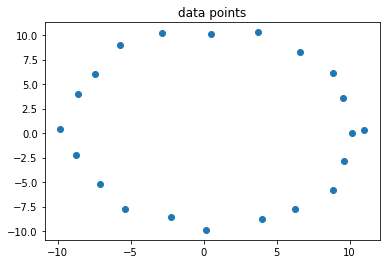

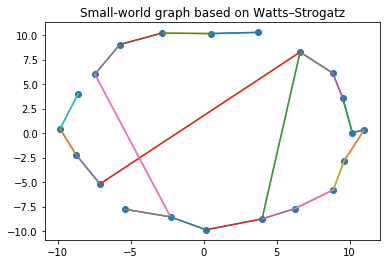

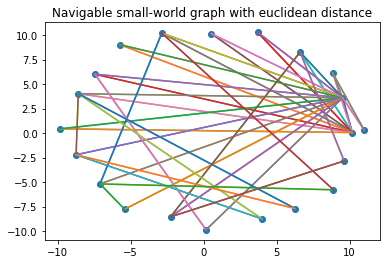

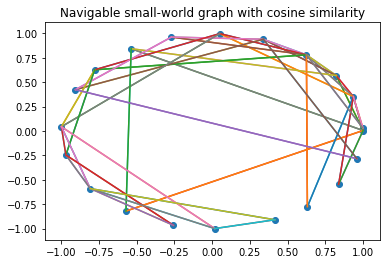

In [34]:
#TODO bonus task
# generate a set of 2d points
from matplotlib import pyplot as plt 
import math

def find_k_closest_euclid(query, dataset, k=5): # should return nodes
    index = []
    for v in dataset:
        index.append((v, np.linalg.norm(query - v.value)))
#     index = list((v, np.dot(query, v.value)) for v in dataset)
    return sorted(index, key=lambda pair: pair[1], reverse=True)[:k]

n=20
r = 10
points = [[np.cos(2*np.pi/n*x)*r,math.sin(2*np.pi/n*x)*r] for x in range(0,n+1)]
points = np.array(points)+np.random.random((21,2))
plt.scatter(points[:,0], points[:,1])
plt.title('data points')
plt.show()

plt.scatter(points[:,0], points[:,1])
G = build_graph(points, K=2, p=0.2)
for node in G:
    for neighbour in node.neighbourhood:
        plt.plot([node.value[0], G[neighbour].value[0]], [node.value[1], G[neighbour].value[1]])
plt.title('Small-world graph based on Watts–Strogatz')
plt.show()


plt.scatter(points[:,0], points[:,1])
G = build_navigable_graph(points, K=2, similarity=find_k_closest_euclid)
for node in G:
    for neighbour in node.neighbourhood:
        plt.plot([node.value[0], G[neighbour].value[0]], [node.value[1], G[neighbour].value[1]])
plt.title('Navigable small-world graph with euclidean distance')
plt.show()

points = norm_vectors(points)
plt.scatter(points[:,0], points[:,1])
G = build_navigable_graph(points, K=2, similarity=find_k_closest2)
for node in G:
    for neighbour in node.neighbourhood:
        plt.plot([node.value[0], G[neighbour].value[0]], [node.value[1], G[neighbour].value[1]])
plt.title('Navigable small-world graph with cosine similarity')
plt.show()

# resulting graphs are different, navigable_graph has more connections
# in this set of points small-world graph based on Watts–Strogatz is more relevant, 
# Navigable small-world graph has a problem of earlier added points being attatched to all new coming 
# points. cosine similarity seems to work better in this case